In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
from networks import FullyConnected
from fem_system import fem
from training import train_pinn_1d, train_fem_loss_1d  
device = "cuda" if torch.cuda.is_available() else "cpu" 
from plot_utilities import plot_data
import matplotlib.font_manager
torch.manual_seed(0)
import random
random.seed(0)
import numpy as np
np.random.seed(0)

$$ u''(x)=2 $$
$$ u=-2 \space on \space x=-1,1 $$


A simple poisson example is tried with pinn combined with fem based loss function.  


In [2]:
l_bc = -2
r_bc = -2
force = 2.0

In [3]:
f_element = fem()

#### Case 1: Using nodal points of FEM as collocation points for PINN

In [4]:
# creating matrices for fem based loss function
nodes_d = 10
h =  2/(nodes_d-1)
A, F = f_element.make_a_matrix(nodes_d, h), f_element.make_f_matrix(nodes_d, h, force)
A, F = f_element.apply_BC(A, F, l_bc, r_bc)

In [5]:
# copying model to have same initialisation for both models
model_1 = FullyConnected(10, 3).to(device)
# copying model to have same initialisation for both models
model_2 = copy.deepcopy(model_1)
model_3 = copy.deepcopy(model_1)
model_4 = copy.deepcopy(model_1)

In [6]:
data_fem =  torch.linspace(-1,1, nodes_d).reshape(nodes_d, 1).requires_grad_().double().to(device)

In [7]:
f = torch.tensor([force], requires_grad = True).to(device)

In [8]:
pinn_trainer = train_pinn_1d(model_1, f, l_bc, r_bc)
fem_loss_trainer =  train_fem_loss_1d(model_2, A, F)

epoch_1 = 1100

loss_1 = pinn_trainer.train(data_fem, epochs=epoch_1)
loss_3 = fem_loss_trainer.train(data_fem, epochs=epoch_1)

0 [5.95672]
1000 [1.04133706]
0 1.3111935643768846
1000 0.06554083383835095


In [9]:
test_in   =  torch.linspace(-1, 1, 50).reshape(50,1).to(device)
U_exact_m = np.asarray([-x*x-1 for x in test_in.detach().cpu().numpy()])
model_1.eval()
model_2.eval()

test_out_1 =  model_1(test_in.double())
test_out_2 =  model_2(test_in.double())

In [10]:
error_pinn = np.mean(np.abs(test_out_1.detach().cpu().numpy() - U_exact_m))
error_femnn = np.mean(np.abs(test_out_2.detach().cpu().numpy()-U_exact_m))

print(f" Error using PINN is {error_pinn} and error using FEM-NN is{error_femnn}")

 Error using PINN is 0.14938117174807888 and error using FEM-NN is0.04269613123844436


In [11]:
var1 = np.concatenate((test_in.detach().cpu().numpy(),test_out_1.detach().cpu().numpy()), axis=1)
var2 = np.concatenate((test_in.detach().cpu().numpy(),test_out_2.detach().cpu().numpy()), axis=1)
var3 = np.concatenate((test_in.detach().cpu().numpy(), U_exact_m), axis=1)

§§§§§§§§§§§§§§§§§§§
Limits are  -1.0 1.0 -2.0 -1.0004165
############################# 5 


findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


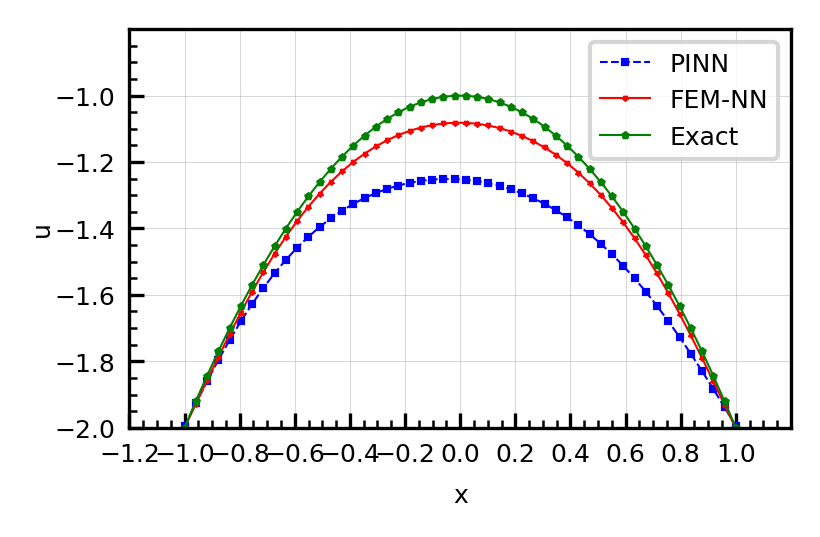

plotting Caarc finished!


In [12]:
plot_data(var1, var2, var3, "one_d_poisson_1900", ["PINN"t,"FEM-NN", "Exact", "x", "u"])

### Case2: More epochs same configuration

In [13]:
# creating matrices for fem based loss function, note: a corase grid is used compared to exact solution (exact = 41, fem loss=3)
nodes_d = 10
h =  2/(nodes_d-1)
A, F = f_element.make_a_matrix(nodes_d, h), f_element.make_f_matrix(nodes_d, h, force)
A, F = f_element.apply_BC(A, F, l_bc, r_bc)

In [14]:
data_fem =  torch.linspace(-1,1, nodes_d).reshape(nodes_d,1).requires_grad_().double().to(device)

In [15]:
f = torch.tensor([force], requires_grad = True).to(device)

In [16]:
pinn_trainer = train_pinn_1d(model_3, f, l_bc, r_bc)
fem_loss_trainer =  train_fem_loss_1d(model_4, A, F)

loss_1 = pinn_trainer.train(data_fem, epochs=3000)
loss_2 = fem_loss_trainer.train(data_fem, epochs=3000)
print(f"Final losses are {loss_1[-1]} , {loss_2[-1]} and {loss_3[-1]} respectively")

0 [5.95672]
1000 [1.04133706]
2000 [0.00479473]
0 1.3111935643768846
1000 0.06554083383835095
2000 0.0005200966321705451
Final losses are [0.00235914] , 0.00020263750123443707 and 0.05571965800554357 respectively


In [17]:
test_in   =  torch.linspace(-1, 1, 50).reshape(50,1).to(device)
U_exact_m = np.asarray([-x*x-1 for x in test_in.detach().cpu().numpy()])
model_3.eval()
model_4.eval()
test_out_1 =  model_3(test_in.double())
test_out_2 =  model_4(test_in.double())

In [18]:
print(np.mean(np.abs(test_out_1.detach().cpu().numpy() - U_exact_m)), np.mean(np.abs(test_out_2.detach().cpu().numpy()-U_exact_m)))

0.03484094738058461 0.00034047447790161553


In [19]:
var1 = np.concatenate((test_in.detach().cpu().numpy(),test_out_1.detach().cpu().numpy()), axis=1)
var2 = np.concatenate((test_in.detach().cpu().numpy(),test_out_2.detach().cpu().numpy()), axis=1)
var3 = np.concatenate((test_in.detach().cpu().numpy(), U_exact_m), axis=1)

§§§§§§§§§§§§§§§§§§§
Limits are  -1.0 1.0 -2.0 -1.0004165
############################# 5 


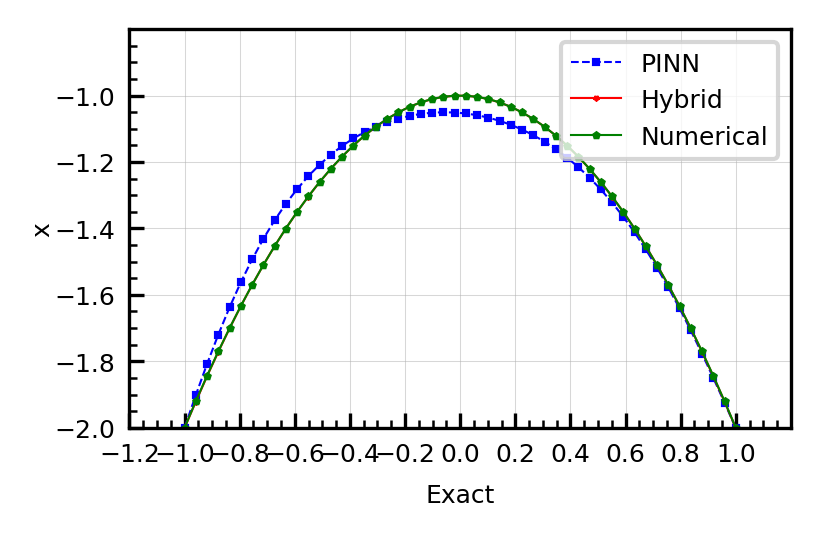

plotting Caarc finished!


In [20]:
plot_data(var1, var2, var3, "one_d_poisson_50_case_2", ["PINN", "Hybrid", "Numerical","Exact", "x", "u"])